# About the dataset 
This Dataset has 4 types of classes .

- Guitar_Sound - 700 Sounds in Train Set
- Drum_Souund - 700 Sounds in Train Set
- Violin_Sound - 700 Sound in Train Set
- Piano_Sound - 528 Sound in Train Set

In Test Set Total 80 audio files are present , 20 From Each Class.

### The dataset can be found in : https://www.kaggle.com/datasets/soumendraprasad/musical-instruments-sound-dataset/data

In [2]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
import scipy.io.wavfile as wav
import matplotlib.pyplot as plt
from scipy import signal
import librosa
import pywt
import librosa.display
from skimage.transform import resize

# Reading the metadata of the train set

In [3]:
train_metadata = pd.read_csv("Metadata_Train.csv")
print(train_metadata)

                             FileName         Class
0                   1-E1-Major 00.wav  Sound_Guitar
1                   1-E1-Major 01.wav  Sound_Guitar
2                   1-E1-Major 02.wav  Sound_Guitar
3                   1-E1-Major 03.wav  Sound_Guitar
4                   1-E1-Major 04.wav  Sound_Guitar
...                               ...           ...
2624          strange-piano-73881.wav   Sound_Piano
2625        the-last-piano-112677.wav   Sound_Piano
2626  this-is-war-version-e-95411.wav   Sound_Piano
2627     tired-ghosts-piano-65013.wav   Sound_Piano
2628              toy-piano-27311.wav   Sound_Piano

[2629 rows x 2 columns]


The metadata shos the name of the file and the class associated 

### Function to get the label of a given filename

In [4]:
def getClass(df,filename):
    result = df.loc[df['FileName'] == filename, 'Class'].values
    return result

# Getting all the .wav files into numpy arrays



In [5]:
base_directory = "Train_submission"
file_names  = os.listdir(base_directory)
print(len(file_names))

2628


In [6]:

def read_wav(file):
    try:
        sr, audio_data = wav.read(file)
        
        if len(audio_data.shape) > 1:
            audio_data = np.mean(audio_data, axis=1).astype(audio_data.dtype)  # Average the channels

        return audio_data, sr
    except Exception as e:
        print(f"Scipy could not read {file}: {e}")
        return None, None

# Getting all the files with the metadata
not all the files are contained in the metadata is an error or i dont know but im pretty sure with this code we can obtainen all the guitar,drum and piano classes

In [7]:
files_set = set()
max = 0
dataset = []
labels = []
sample_rates = []
for i, f in train_metadata.iterrows():
    wav_file = f"Train_submission/{f['FileName']}"
    if f['FileName'] not in files_set:
        data, sr = read_wav(wav_file)
        #print(f"{f['FileName']} --- {data.shape}--------{f['Class']}, ")
        dataset.append(data)
        labels.append(f['Class'])
        files_set.add(f['FileName'])
        sample_rates.append(sr)
        if data.shape[0] > max : 
            max = data.shape[0]
        


C:\Users\Carlo\AppData\Local\Temp\ipykernel_12008\1912964983.py:3: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sr, audio_data = wav.read(file)


### files obtained

In [8]:
print(files_set)
print(len(files_set))

{'046578_tribal-drum-rhythms-03wav-68096.wav', 'ROOM_room6_MUS_beethoven1_DEV_amazon.wav', 'FS_Lick3_MN.wav', 'G53-54209-1111-179.wav', 'WaveDrum02_43HH (8).wav', 'slow_classical_4_60BPM.wav', 'FS_B_muted5.wav', 'G53-60405-1111-201.wav', 'digital-pulse-140-2-122269.wav', 'classical_5_70BPM.wav', 'G53-55400-1111-196.wav', 'ROOM_room3_MUS_scale_DEV_redmi.wav', 'AR_B_fret_0-20.wav', 'ROOM_room6_MUS_chords_DEV_ipad.wav', 'G53-64505-1111-00136.wav', 'TechnoDrum01_07KDtrain.wav', 'DRUM_SOUND (74).wav', 'G53-50110-1111-245.wav', 'reggae_2_120BPM.wav', 'AR_Lick7_KN.wav', 'AR_A_fret_0-20.wav', 'DRUM_SOUND (67).wav', 'DRUM_SOUND (24).wav', 'asian-gong-102397.wav', '066166_qui-c39est-qu39est-tombe-loop-t85wav-39366.wav', 'G53-65601-1111-223.wav', 'WaveDrum02_43HH (109).wav', 'deep-drums-42782.wav', 'new-9-42628.wav', 'FS_DN_III_VIII_XIV.wav', 'G53-54304-1111-265.wav', 'ROOM_room2_MUS_chords_DEV_ipad.wav', 'drum-beat-bpm-120-113150.wav', 'DRUM_SOUND (64).wav', 'WaveDrum02_39KD (128).wav', 'WaveDru

### Getting the violin label

In [9]:
missing = set()
for f in file_names:
    if f not in files_set and f not in missing:
        missing.add(f)
#print(missing)
#print(len(missing))

In [10]:
for m in missing:
    wav_file = f"Train_submission/{m}"
    data , sr = read_wav(wav_file)
    dataset.append(data)
    labels.append("Sound_Violin")
    sample_rates.append(sr)
    #print(f"{m}    data {data.shape} --- violin")
    if data.shape[0] > max :
        max = data.shape[0]

In [11]:
print(max)

3616200


In [12]:
print(len(dataset))
print(len(labels))
print(len(sample_rates))

2628
2628
2628


# Preprocecing


## Functions to get a 2D representation of the data 

In [13]:
def plot_matrix(list_matrix, list_titles, cmap='viridis'):    
    n = len(list_matrix)  
    plt.figure(figsize=(12, 12))  
    
    for i, matrix in enumerate(list_matrix):
        plt.subplot(2, 2, i + 1)  
        plt.imshow(matrix, aspect='auto', origin='lower', cmap=cmap)
        plt.title(list_titles[i])  
        plt.colorbar(label='Intensity')  
    
    plt.tight_layout()  
    plt.show()

In [14]:
def normalize_signal(signal):
    signal = signal.astype(np.float32)

    max_val = np.max(np.abs(signal))
    
    if max_val > 0:
        signal = signal / max_val
    
    return signal



def get_full_spectrum(signal, sample_rate):
    fft_values = np.fft.fft(signal)  
    frequencies = np.fft.fftfreq(len(signal), 1 / sample_rate)  
    magnitude_spectrum = np.abs(fft_values)   
    return frequencies, magnitude_spectrum



def get_fixed_size_spectrogram(signal_data, sample_rate, target_shape=(128, 128), nperseg=256, noverlap=128):
    frequencies, times, Sxx = signal.spectrogram(signal_data, sample_rate, nperseg=nperseg, noverlap=noverlap)

    log_Sxx = 10 * np.log10(Sxx + 1e-10)  
    spectrogram_resized = resize(log_Sxx, target_shape, mode='reflect', anti_aliasing=True)

    return spectrogram_resized


def get_fixed_size_chromagram(signal_data, sample_rate, target_shape=(128, 128)):

    chromagram = librosa.feature.chroma_stft(y=signal_data, sr=sample_rate)
    

    chromagram_resized = resize(chromagram, target_shape, mode='reflect', anti_aliasing=True)
    
    return chromagram_resized

def get_fixed_size_wavelet(signal, scales, wavelet='cmor', target_shape=(128, 128)):
    
    
    coefficients, frequencies = pywt.cwt(signal, scales, wavelet)
    
    # Resize the wavelet coefficients to the desired target shape
    coefficients_resized = resize(np.abs(coefficients), target_shape, mode='reflect', anti_aliasing=True)
    
    return coefficients_resized

# Chromagram

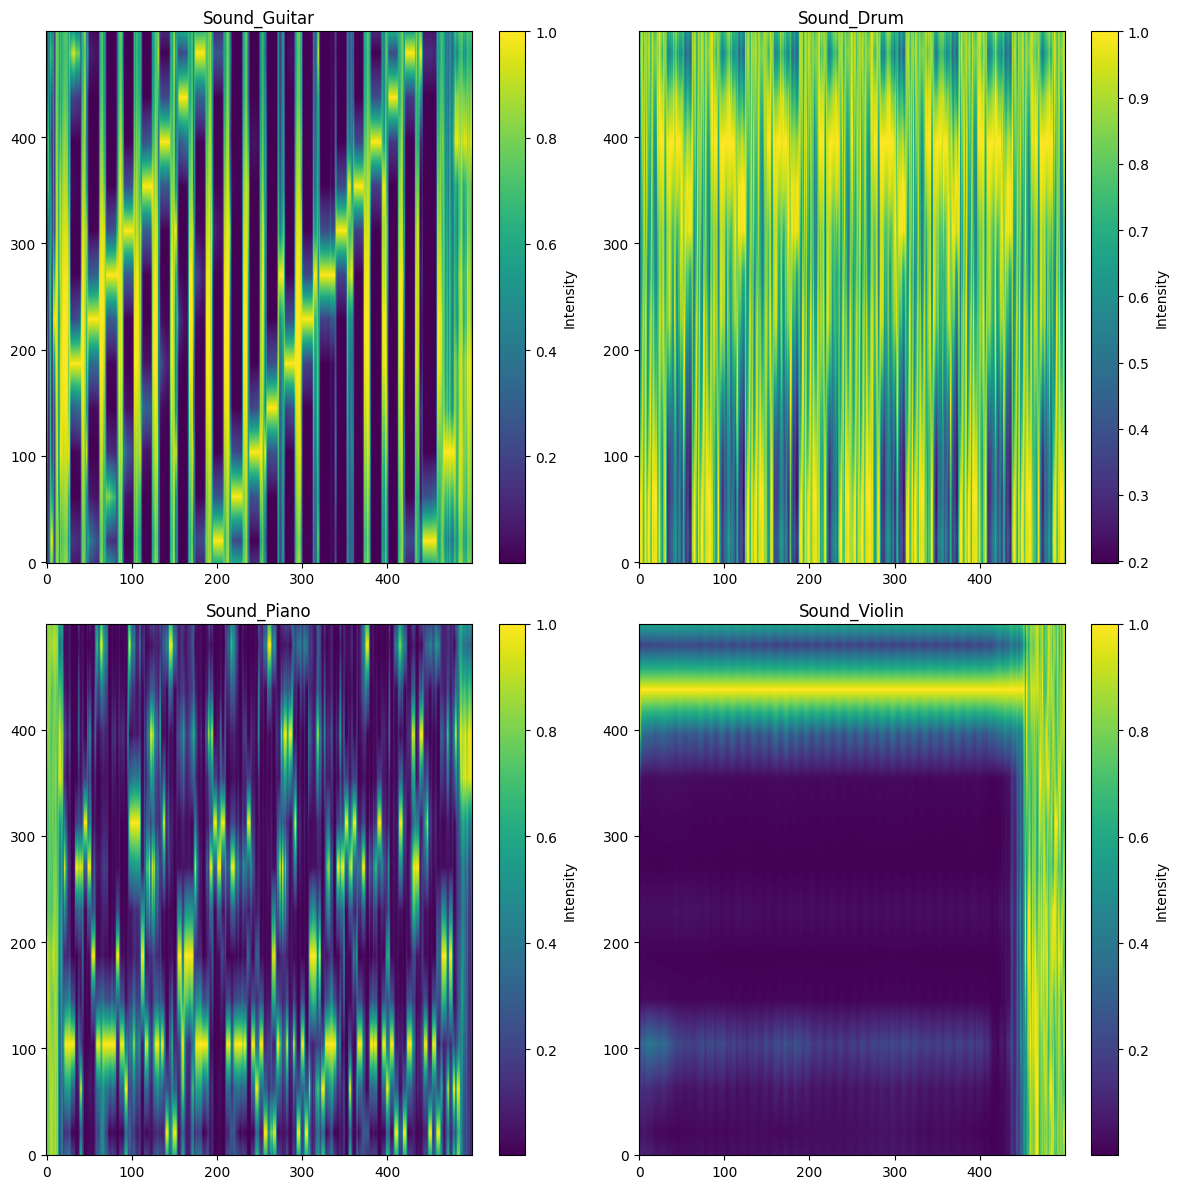

In [15]:
indices = [27, 1001, 1900, 2017]  # Dataset indices you want to plot
target_shape = (500, 500)  # Fixed size for the matrix

mats = []
labs = []
for i in indices:
    mat = get_fixed_size_chromagram(normalize_signal(dataset[i]),sample_rates[i],target_shape)
    mats.append(mat)
    labs.append(labels[i])


plot_matrix(mats,labs)



# Spectogram

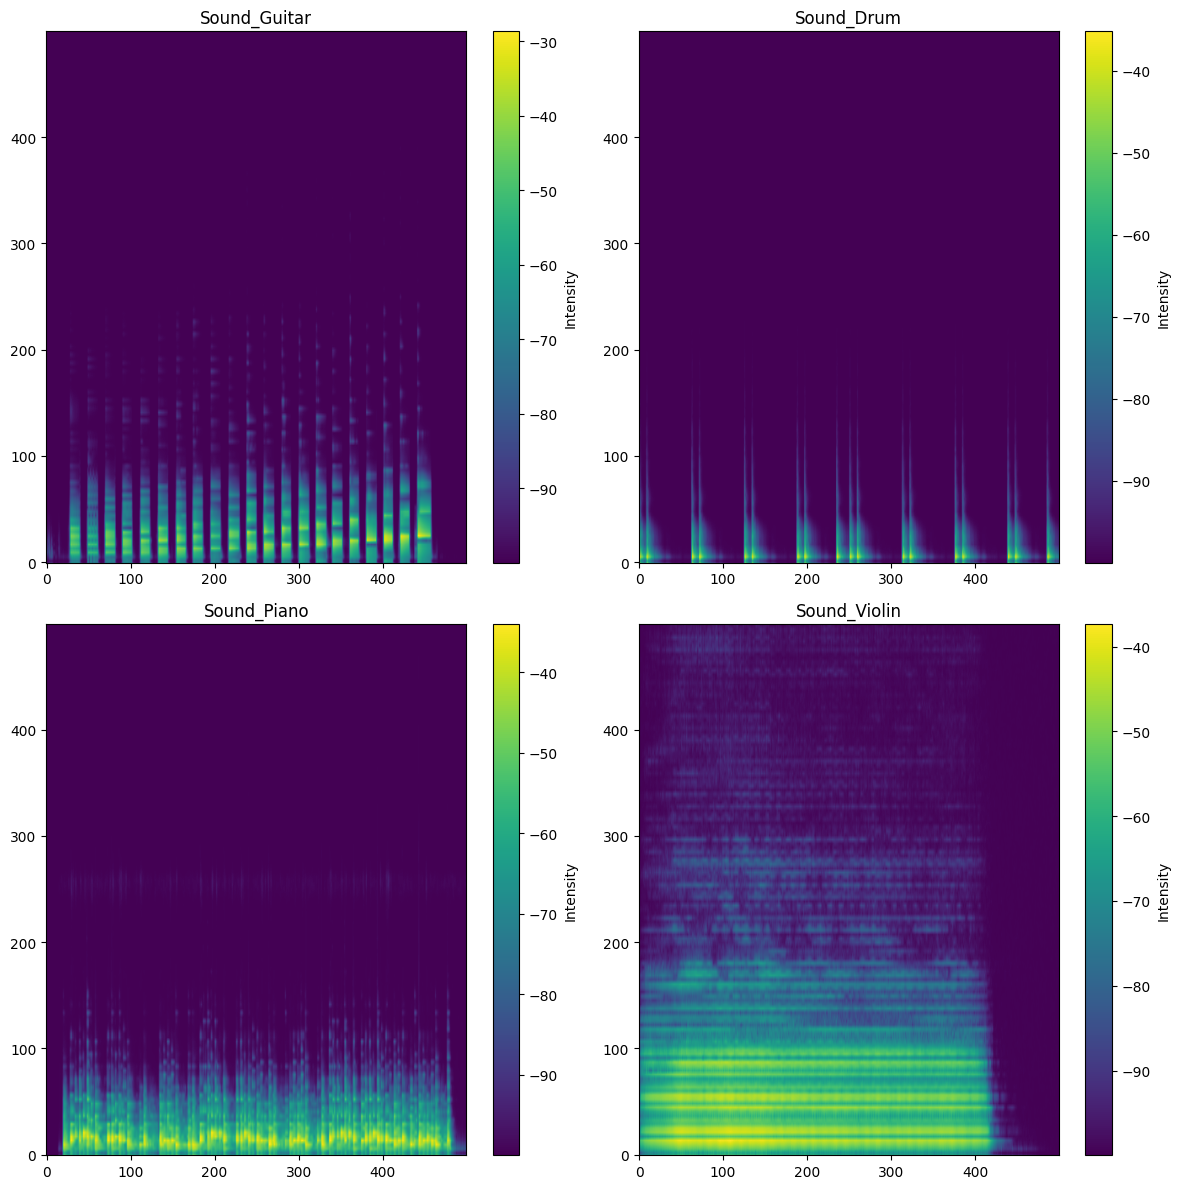

In [16]:
mats = []
labs = []
for i in indices:
    mat = get_fixed_size_spectrogram(normalize_signal(dataset[i]),sample_rates[i],target_shape)
    mats.append(mat)
    labs.append(labels[i])


plot_matrix(mats,labs)


# MODELS

### Class dictionary

In [17]:
string_int = {"Sound_Piano":0, "Sound_Violin":1,"Sound_Drum":2, "Sound_Guitar":3}
int_string = {0:"Sound_Piano", 1: "Sound_Violin", 2 : "Sound_Drum", 3: "Sound_Guitar"}

## Spectogram Model

In [19]:
DATA = []
DATA_LABELS = []
target_shape = (264,264)
for i in range(len(dataset)):
    mat = get_fixed_size_spectrogram(normalize_signal(dataset[i]),sample_rates[i],target_shape = target_shape)
    DATA.append(mat)
    DATA_LABELS.append(string_int[labels[i]])

In [20]:
INPUT = np.stack(DATA)
CLASS = np.stack(DATA_LABELS)

In [21]:
INPUT = np.expand_dims(INPUT, axis=-1)

In [22]:
print(INPUT.shape)
print(CLASS.shape)

(2628, 264, 264, 1)
(2628,)


In [32]:
import tensorflow as tf

model = tf.keras.Sequential([

    tf.keras.layers.Conv2D(164, (5, 5), activation='relu', input_shape=(264, 264, 1)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    

    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),

    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),


    tf.keras.layers.Flatten(),


    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax') 
])

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Print the model summary to verify the architecture
model.summary()


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)               │ (None, 260, 260, 164)  │         4,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 130, 130, 164)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 128, 128, 128)  │       189,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 62, 62, 64)     │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 31, 31, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 29, 29, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │       802,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 10)             │           330 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,099,186 (4.19 MB)

 Trainable params: 1,099,186 (4.19 MB)

 Non-trainable params: 0 (0.00 B)

In [33]:

history = model.fit(INPUT, CLASS, epochs=10, batch_size=16)

Epoch 1/10
165/165 ━━━━━━━━━━━━━━━━━━━━ 514s 3s/step - accuracy: 0.2497 - loss: 2.4117
Epoch 2/10
165/165 ━━━━━━━━━━━━━━━━━━━━ 531s 3s/step - accuracy: 0.3198 - loss: 1.3539
Epoch 3/10
165/165 ━━━━━━━━━━━━━━━━━━━━ 525s 3s/step - accuracy: 0.5683 - loss: 1.0015
Epoch 4/10
165/165 ━━━━━━━━━━━━━━━━━━━━ 506s 3s/step - accuracy: 0.6618 - loss: 0.7754
Epoch 5/10
165/165 ━━━━━━━━━━━━━━━━━━━━ 529s 3s/step - accuracy: 0.7490 - loss: 0.6300
Epoch 6/10
165/165 ━━━━━━━━━━━━━━━━━━━━ 533s 3s/step - accuracy: 0.7677 - loss: 0.5836
Epoch 7/10
165/165 ━━━━━━━━━━━━━━━━━━━━ 507s 3s/step - accuracy: 0.8206 - loss: 0.4895
Epoch 8/10
165/165 ━━━━━━━━━━━━━━━━━━━━ 511s 3s/step - accuracy: 0.7985 - loss: 0.5243
Epoch 9/10
165/165 ━━━━━━━━━━━━━━━━━━━━ 560s 3s/step - accuracy: 0.8653 - loss: 0.4197
Epoch 10/10
165/165 ━━━━━━━━━━━━━━━━━━━━ 538s 3s/step - accuracy: 0.8920 - loss: 0.3248


In [45]:
base_directory = "Test_submission/Test_submission"
file_names  = os.listdir(base_directory)
print(len(file_names))

80


In [47]:
mats = []
for f in file_names:
    test = read_wav(base_directory + "/" + f)
    mat = get_fixed_size_spectrogram(test[0],test[1],target_shape=(264,264))
    mats.append(mats)
mats = np.stack(mats)

C:\Users\Carlo\AppData\Local\Temp\ipykernel_12008\1912964983.py:3: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sr, audio_data = wav.read(file)


In [43]:
print(mats.shape)
mats = np.expand_dims(mats,axis = -1)
print(mats.shape)

ValueError: Exception encountered when calling Conv2D.call().

[1mNegative dimension size caused by subtracting 5 from 1 for '{{node sequential_3_1/conv2d_9_1/convolution}} = Conv2D[T=DT_FLOAT, data_format="NHWC", dilations=[1, 1, 1, 1], explicit_paddings=[], padding="VALID", strides=[1, 1, 1, 1], use_cudnn_on_gpu=true](sequential_3_1/ExpandDims, sequential_3_1/conv2d_9_1/convolution/ReadVariableOp)' with input shapes: [32,264,1,1], [5,5,1,164].[0m

Arguments received by Conv2D.call():
  • inputs=tf.Tensor(shape=(32, 264, 1, 1), dtype=float32)